# Random forest for pianist classification

## Import dependencies, set constants etc.

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_validate

from src import utils
import src.visualise.visualise_utils as vutils
from src.features.features_utils import FeatureExtractor

In [2]:
# Define target/prediction variables
EXOG_INS = 'piano'
PREDICTION = 'pianist'

In [3]:
# Define predictor variables
PREDICTORS = [
    # Coupling of the pianist to the drummer, bassist, and themselves (i.e. influence of)
    'coupling_drums', 'coupling_bass', 'self_coupling',
    # Coupling of the bassist and drummer to the pianist (i.e. influence on)
    'coupling_bass_piano', 'coupling_drums_piano',
    # Tempo slope of average group position
    'tempo_slope',
    # Average tempo of the whole recording
    # TODO: should we use the tempo of the average group position?
    'tempo',
    # Median variability of 1/4 notes across a four-bar window
    # TODO: this should be a four-second window, not four-bar window!
    'rolling_std_median',
    # Average/variability in complexity of the IOIs across a four-bar window
    'entropy_mean', 'entropy_std',
    # Mean and variability of BUR values
    'bur_mean', 'bur_std',
    # Mean and variability of notes per second
    'ed_per_second_mean', 'ed_per_second_std',
    # Precision to each of our ensemble partners
    'bass_async_mean_pairwise_asynchrony','drums_async_mean_pairwise_asynchrony',
    # Accuracy to the whole group
    'mean_relative_asynchrony'
]

In [50]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_mean', 'bur_std'],
    'Density': ['ed_per_second_mean', 'ed_per_second_std'],
    'Synchrony': ['bass_async_mean_pairwise_asynchrony', 'drums_async_mean_pairwise_asynchrony', 'mean_relative_asynchrony'],
    'Complexity': ['entropy_median', 'entropy_mean', 'entropy_std'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_drums_piano', 'coupling_bass_piano'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope']
}

In [4]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 250

In [5]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Load in data
We start by loading in the data we extracted from our `corpus_chronology` in `src\features\extract_features.py`. This gives us a list of `FeatureExtractor` classes (defined in `src\features\features_utils.py`).

In [6]:
features: list[FeatureExtractor] = utils.unserialise_object(fr'{utils.get_project_root()}\models\extracted_features_corpus_chronology')

We can now iterate through each `FeatureExtractor` class (equivalent to iterating through each track) and gather the attributes from this class that correspond to the features defined in `PREDICTORS`.

In [7]:
res = []
# Equivalent to iterating through each track
for track in features:
    track_res = {}
    # Iterate through each instrument in the trio
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # These are the results for the pianist
        if instr == EXOG_INS:
            be = track.IOI_onsetsrolling[EXOG_INS][4].summary_dict
            track_res.update({
                'entropy_mean': be['rolling_binary_entropy_mean'],
                'entropy_std': be['rolling_binary_entropy_std'],
                'entropy_count_nonzero': be['rolling_binary_entropy_count_nonzero'],
                **track.metadata[EXOG_INS],
                **track.IOI_beats[EXOG_INS].summary_dict,
                **track.BURs[EXOG_INS].summary_dict,
                **track.tempo_slope['group'].summary_dict,
                **track.asynchrony[EXOG_INS].summary_dict,
                **track.phase_correction[EXOG_INS][0].summary_dict[0],
                **track.event_density[EXOG_INS][1].summary_dict,
                **track.IOI_beatsrolling[EXOG_INS][4].summary_dict
            })
        # For the drummer and bassist, we just want their coupling to the piano and the number of observations in their regression
        else:
            track_res.update({
                f'coupling_{instr}_piano': track.phase_correction[instr][0].summary_dict[0]['coupling_piano'],
                f'nobs_{instr}': track.phase_correction[instr][0].summary_dict[0]['nobs']
            })
    # Once we have all the data for one instrument, append this to our results list
    res.append(track_res)

We can now convert all of these features to a dataframe, sort by the pianist in the recording, and print a few rows.

In [8]:
df = pd.DataFrame(res).sort_values('pianist').reset_index(drop=True)

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features, which we can then impute or drop. We start by removing tracks where EITHER more than 1/3 of the audio is silent OR more than 2/3 of beats could not be matched with an onset. We remove these tracks completely, as we cannot be sure that any of the data is valid due to problems with either the source separation or onset detection on these tracks.

In [9]:
clean = df[(df['missing_beats_fraction'] < 2/3) | (df['fraction_silent'] < 1/3)].sort_values(by='pianist').reset_index(drop=True)

For the remaining variables, we set outlying values to `np.nan` so that we can set them to the group (pianist) average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [10]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs'] = clean[f'nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

For the same reason, we clean `coupling_bass_piano` (i.e. bass coupling to piano) when `nobs_bass < 30` (sim. for `coupling_drums_piano` and `nobs_drums`)

In [11]:
for col in ['bass', 'drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs_{col}'] = clean[f'nobs_{col}'].fillna(0)
    clean.loc[clean[f'nobs_{col}'] < 30, f'coupling_{col}_piano'] = np.nan

We clean `bur_mean` and `bur_std` when `0.25 <= average_bur <= 4` (these are the values discussed by Corcoran and Frieler) OR `bur_count_nonzero < 10` (we have fewer than 10 BURs in the track).

In [12]:
for col in ['bur_mean', 'bur_std']:
    clean.loc[clean['bur_mean'] < 1/4, col] = np.nan
    clean.loc[clean['bur_mean'] > 4, col] = np.nan
    clean.loc[clean['bur_count_nonzero'] < 10, col] = np.nan

We clean `bass/drums_async` when `bass/drums_async_count_nonzero < 10`, i.e. we played on fewer than 10 beats with our partner.

In [13]:
for col in ['bass', 'drums']:
    clean.loc[clean[f'{col}_async_count_nonzero'] < 10, f'{col}_async_mean_pairwise_asynchrony'] = np.nan

We clean `mean_relative_asynchrony` when the combined `bass_async_count_nonzero + drums_async_count_nonzero < 20`, meaning we played on fewer than 20 beats with either of our partners.

In [14]:
# We sum up the asynchrony count for both partners in the trio
as_count = clean.loc[:, ['bass_async_count_nonzero', 'drums_async_count_nonzero']].sum(axis=1)
clean.loc[as_count < 20, 'mean_relative_asynchrony'] = np.nan

We clean `tempo_slope` when `tempo_slope.abs() < 0.15`, i.e. we accelerated (or decelerated) by more than 0.15 beats-per-minute-per-second. This is the upper limit of values suggested to be realistic for jazz ensembles in the control condition of our previous experiment.

In [15]:
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_slope'] = np.nan

We clean `rolling_std_median` when `rolling_std_median > 0.4`, i.e. the median standard deviation for a four-second window of 1/4 note beats is greater than 40 milliseconds. This is the upper limit of values for this variable from our earlier experiment.

In [16]:
clean.loc[clean['rolling_std_median'] > 0.4, 'rolling_std_median'] = np.nan

We clean `entropy_median` and `entropy_std` when we have fewer than 5 complete four-second windows over which to calculate this.

In [17]:
for col in ['mean', 'std']:
    clean.loc[clean['entropy_count_nonzero'] < 5, f'entropy_{col}'] = np.nan

### Impute missing values based on pianist averages
We can now group by our pianists and set the `np.nan` values to the mean for that pianist.

In [18]:
X = clean.groupby(PREDICTION)[PREDICTORS].transform(lambda x: x.fillna(x.mean()))

### Encode categorical prediction variable
Next, we need to encode our predictor variable (currently a list of names) to integers.

In [19]:
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

## Random Forest modelling
### Create training and testing data
We use a train/test split of 80/20% of the data, respectively. We stratify our groups by pianist, so we maintain the same proportion of musicians in the training/test set as can be found in the initial dataset. This is important because, with the random nature of the split, otherwise we might end up not training on particular pianists at all.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=SEED, stratify=y)

In [21]:
# If we've split the data up evenly, we should have results from all ten pianists in our test and training set
assert y_test.nunique() == 10
assert y_train.nunique() == 10

### Create the baseline model
Here, we just make random predictions of the pianist in each track in the test set.

In [22]:
accuracy_random = accuracy_score(y_test, np.random.randint(y.min(), y.max(), len(y_test)))
print(f"Random guess accuracy: {round(accuracy_random * 100, 2)}%")

Random guess accuracy: 14.04%


As expected, we'll be correct approximately one in ten times if we just guess the pianist at random.

### Create the initial model
This just uses the default parameters of `RandomForestClassifier`, without any attempt at optimisation.

In [23]:
rf_init = RandomForestClassifier(random_state=SEED)
results = cross_validate(
    estimator=rf_init,
    X=X_train,
    y=y_train,
    groups=y_train,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=False),
    scoring='balanced_accuracy',
)
accuracy_init = results['test_score'].mean() * 100
print(f"Initial model accuracy on training set: {round(accuracy_init, 2)}%")

Initial model accuracy on training set: 39.13%


Even without any parameter tuning, the model is nearly three times as accurate as chance alone when predicting the training data.

### Hyperparameter tuning
Now, we use `RandomizedSearchCV` to test various possible options of parameters and find the optimized settings.

In [24]:
# Create the classifier object
rscv_rf = RandomForestClassifier(random_state=SEED)

In [25]:
# Define the parameter grid to sample from
rscv_params = dict(
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(50, 1000, 50)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(10, 100, 10)]],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [26]:
# Define the RandomizedSearchCV object
rscv = RandomizedSearchCV(
    estimator=rscv_rf,
    scoring='balanced_accuracy',
    param_distributions=rscv_params,
    n_iter=N_ITER,
    n_jobs=N_JOBS,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=False),
    random_state=SEED,
    verbose=1,
)

In [27]:
# Fit the random search object to the data
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500, 550, 600, 650,
                                                         700, 750, 800, 850,
                                                         900, 950]},
                   random_state=42, scoring='balanced_accuracy', verbose=1)

In [28]:
# Get the parameters from the best estimate
best_params = rscv.best_estimator_.get_params()

In [146]:
rf_best = RandomForestClassifier(**best_params)
results_best = cross_validate(
    estimator=rf_best,
    X=X_train,
    y=y_train,
    groups=y_train,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=False),
    scoring='balanced_accuracy',
    return_estimator=True
)
accuracy_best = results_best['test_score'].mean() * 100
print(f"Optimized model accuracy: {round(accuracy_best, 2)}%")
print(f'Improvement over initial model: {round(accuracy_best - accuracy_init, 2)}%')

Optimized model accuracy: 45.7%
Improvement over initial model: 6.57%


Optimization lead to an increase in accuracy over the initial model when predicting the training set of approximately +6%.

### Evaluate optimized model performance on test data
Now we fit the best model to the training data and use this to predict the test data, which we haven't used up to now. This gives us an impression as to how well the model performs on completely new data.

In [30]:
rf_best.fit(X_train, y_train)
best_pred = rf_best.predict(X_test)
accuracy_test = accuracy_score(y_test, best_pred) * 100
print(f"Optimized model accuracy on test data: {round(accuracy_best, 2)}%")

Optimized model accuracy on test data: 45.7%


## Plot results

### Plot feature importance
Which rhythmic features are most important in defining the personal style of a particular pianist?

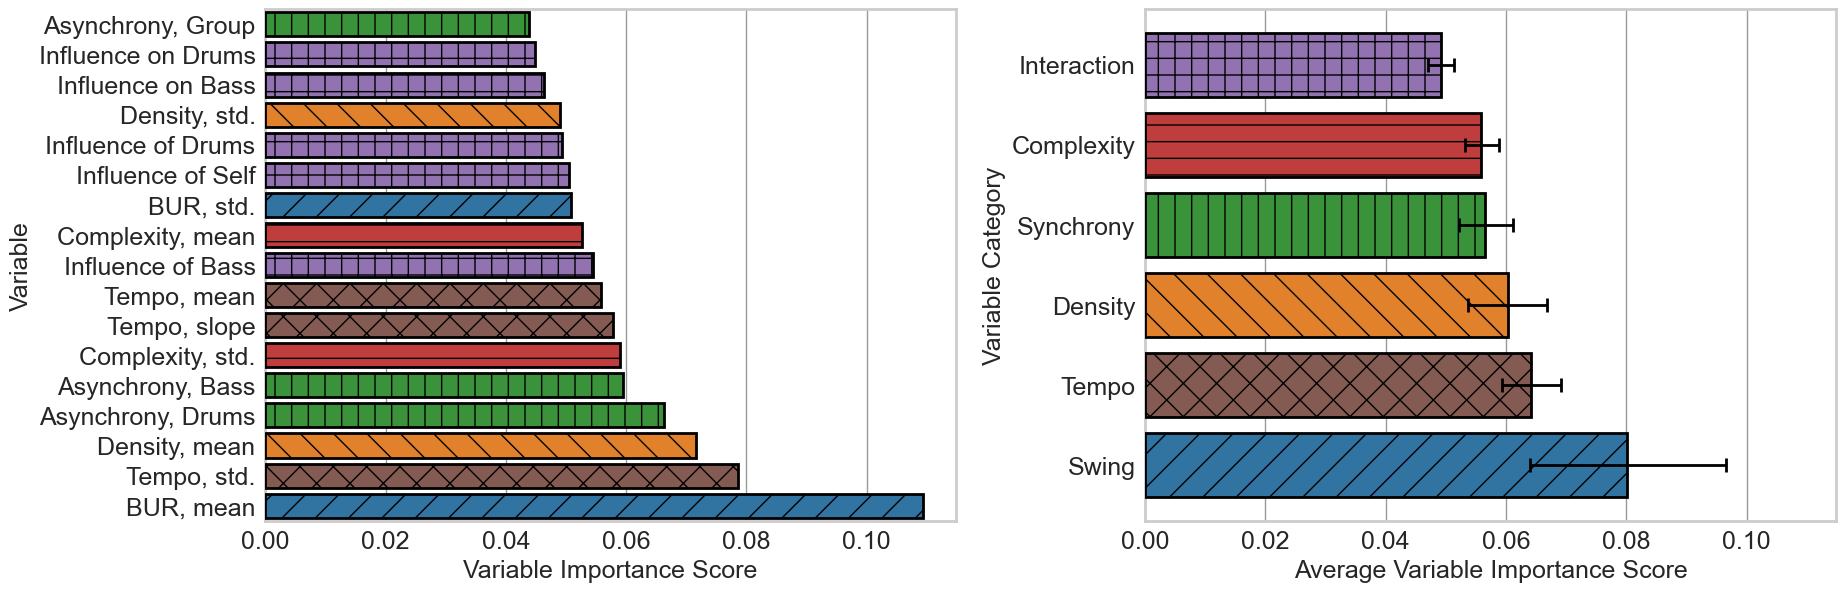

In [213]:
class BarPlotFeatureImportances(vutils.BasePlot):
    """Creates two barplots, showing (1) importance of all features and (2) average importance of feature category"""
    # These are the keywords we apply to all bar plots
    bar_kws = dict(
        dodge=False, edgecolor=vutils.BLACK, errorbar=None,
        lw=vutils.LINEWIDTH, seed=SEED, capsize=0.1, width=0.8,
        ls=vutils.LINESTYLE, hue_order=PREDICTORS_CATEGORIES.keys(),
        zorder=3, estimator=np.mean,
    )
    # These are the keywords we apply to all error bars
    err_kws = dict(
        zorder=5, fmt='', color=vutils.BLACK, ls='', capsize=5,
        elinewidth=vutils.LINEWIDTH, markeredgewidth=vutils.LINEWIDTH
    )
    # These are the mappings we apply to the raw feature names
    col_mapping = {
        'bur_mean': 'BUR, mean',
        'ed_per_second_mean': 'Density, mean',
        'rolling_std_median': 'Tempo, std.',
        'entropy_median': 'Complexity, mean',
        'entropy_mean': 'Complexity, mean',
        'entropy_std': 'Complexity, std.',
        'tempo': 'Tempo, mean',
        'ed_per_second_std': 'Density, std.',
        'coupling_bass': 'Influence of Bass',
        'bass_async_mean_pairwise_asynchrony': 'Asynchrony, Bass',
        'drums_async_mean_pairwise_asynchrony': 'Asynchrony, Drums',
        'tempo_slope': 'Tempo, slope',
        'mean_relative_asynchrony': 'Asynchrony, Group',
        'bur_std': 'BUR, std.',
        'self_coupling': 'Influence of Self',
        'coupling_drums_piano': 'Influence on Drums',
        'coupling_bass_piano': 'Influence on Bass',
        'coupling_drums': 'Influence of Drums'
    }
    # This creates a new dictionary with a unique hash for each predictor category
    hatches = {k: h for k, h in zip(PREDICTORS_CATEGORIES.keys(), vutils.HATCHES)}

    def __init__(self, importances: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'random_forest_plots\barplot_feature_importances_{self.corpus_title}', **kwargs)
        # Create both dataframes
        self.df = self._format_df(importances)
        self.importances = self._format_individual_df(self.df)
        self.grouped_importances = self._format_grouped_df(self.df)
        # Create subplot matrix
        self.fig, self.ax = plt.subplots(nrows=1, ncols=2, figsize=(vutils.WIDTH, vutils.WIDTH / 3), sharex=True, sharey=False)

    def _format_df(self, importances: pd.Series) -> pd.DataFrame:
        """Formats raw feature importance scores"""
        def get_category(val):
            """Returns the correct category for a given feature"""
            for cat, vals in PREDICTORS_CATEGORIES.items():
                if val in vals:
                    return cat

        # Initial formatting to the dataframe
        importances = (
            importances.reset_index(drop=False)
            .rename(columns={'index': 'variable', 0: 'value'})
            .sort_values(by='value', ascending=True)
        )
        # Get the category for each feature and format the variable name
        importances['category'] = importances['variable'].apply(get_category)
        importances['variable_'] = importances['variable'].map(self.col_mapping)
        return importances

    @staticmethod
    def bootstrap(vals):
        true_mean = np.mean(vals)
        boot = [vals.sample(frac=1, random_state=i, replace=True).mean() for i in range(vutils.N_BOOT)]
        low = abs(np.quantile(boot, 0.05) - true_mean)
        high = abs(np.quantile(boot, 0.95) - true_mean)
        return low, true_mean, high

    def _format_grouped_df(self, df_: pd.DataFrame) -> pd.DataFrame:
        res_ = []
        for idx, cat in df_.groupby('category'):
            low, true_mean, high = self.bootstrap(cat['value'])
            res_.append(dict(category=idx, value=true_mean, low=low, high=high))
        return (
            pd.DataFrame(res_)
            .sort_values(by='value', ascending=True)
            .reset_index(drop=True)
        )

    def _format_individual_df(self, df_: pd.DataFrame):
        res_ = []
        for idx, cat in df_.groupby('variable_'):
            low, true_mean, high = self.bootstrap(cat['value'])
            res_.append(dict(variable_=idx, value=true_mean, low=low, high=high, category=cat['category'].iloc[0]))
        return (
            pd.DataFrame(res_)
            .sort_values(by='value', ascending=True)
            .reset_index(drop=True)
        )


    def _create_plot(self) -> plt.Axes:
        """Creates all plots in seaborn with given arguments"""
        sns.barplot(
            data=self.importances, x='value', y='variable_', hue='category',
            ax=self.ax[0], **self.bar_kws
        )
        g = sns.barplot(
            data=self.grouped_importances, x='value', y='category',
            hue='category', ax=self.ax[1],  **self.bar_kws
        )
        g.errorbar(
            self.grouped_importances['value'],
            self.grouped_importances['category'],
            xerr=[self.grouped_importances['low'], self.grouped_importances['high']],
            **self.err_kws
        )

    def add_hatches(self, ax: plt.Axes, df: pd.DataFrame) -> None:
        """Adds correct hatches to a barplot by category"""
        # Get the bars that are actually drawn on the plot, i.e. with non-zero width
        patches = [patch for patch in ax.patches if not np.isnan(patch.get_width())]
        # Sort these patches, so they align with the structure of our dataframe
        patches.sort(key=lambda x: x.get_width(), reverse=False)
        # Iterate through each patch and row together and set the hatch correctly
        for patch, (idx, val) in zip(patches, df.iterrows()):
            patch.set_hatch(self.hatches[val['category']])

    def _format_ax(self) -> None:
        """Formats axis-level properties"""
        # Set variable labelling
        self.ax[0].set(ylabel='Variable', xlabel='Variable Importance Score')
        self.ax[1].set(ylabel='Variable Category', xlabel='Average Variable Importance Score')
        # Iterate through each axis and the corresponding data
        for ax, df in zip(self.ax.flatten(), [self.importances, self.grouped_importances]):
            # Remove the legend
            ax.get_legend().remove()
            # Set the width of the edges and ticks
            plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH)
            ax.tick_params(axis='both', width=vutils.TICKWIDTH)
            # Add a vertical grid
            ax.grid(zorder=0, axis='x', **vutils.GRID_KWS)
            # Add in the hatches to the bars
            self.add_hatches(ax, df)

    def _format_fig(self) -> None:
        """Formats figure-level attributes"""
        self.fig.tight_layout()


# Create a series containing feature importance from the model and feature names from the training data
feature_importance_cv = pd.concat([pd.Series(est.feature_importances_, index=X_train.columns) for est in results_best['estimator']])
BarPlotFeatureImportances(feature_importance_cv).create_plot()

### Plot prediction errors by pianist
Which pianist's style is easiest to predict based on rhythmic features alone?

In [145]:
cm

array([[3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [1, 0, 2, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 3, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 1, 4, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 1, 2],
       [0, 1, 1, 0, 0, 0, 3, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 3, 0, 1],
       [0, 2, 1, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 3, 1, 1, 0, 0]], dtype=int64)

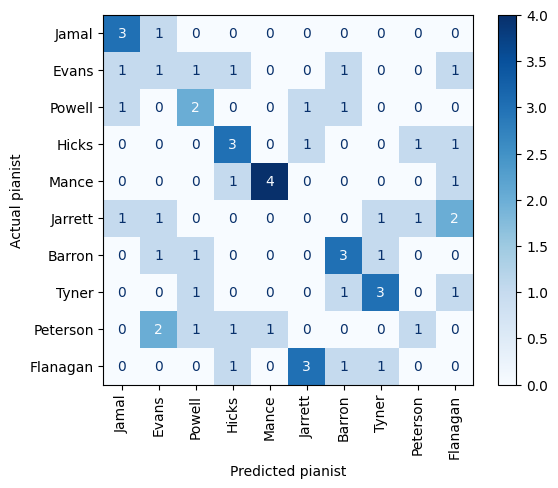

In [32]:
cm = confusion_matrix(y_test, best_pred)
d = ConfusionMatrixDisplay(confusion_matrix=cm, ).plot(cmap='Blues')
fig, ax = d.figure_, d.ax_
surnames = [l.split(' ')[-1] for l in pianist_labels]
ax.set(yticklabels=surnames, ylabel='Actual pianist', xlabel='Predicted pianist')
ax.set_xticklabels(surnames, rotation=90, ha='center')
plt.show()